In [163]:
from glob import glob
import os 

import ipywidgets as widgets

import pandas as pd
from datetime import datetime, timedelta

import requests
import s3fs
import boto3

from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

from random import sample


from retrying import retry
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

# Planet Labs Imagery Ordering 
**Tony Cannistra, 2019**


This notebook describes ordering imagery from Planet Labs overlapping an area of interest. We'll make use of the [`porder`](https://github.com/samapriya/porder) command-line tool. **Note**: In order to run these commands in this notebook, `porder` requires a `.planet.json` file in your home directory with the following format: 

```
{
    "key" : "<planet API key>"
}
```

If you have the [Planet CLI](https://planetlabs.github.io/planet-client-python/cli/index.html) installed, you can run `planet init` to place this file in the correct place for `porder`.

## ASO Collect Selection 

In the space below, provide a directory to search for ASO collect `.tif` files: 

In [12]:
imgDir = widgets.Text()
imgDir

Text(value='')

Now select an ASO collect: 

In [24]:
collect = widgets.Select(
    options = glob(imgDir.value + "/*.tif")
)
collect

Select(options=('/tmp/work/ASO_3M_SD_USCOCB_20180330.tif', '/tmp/work/ASO_3M_SD_USCOCB_20180330_binary.tif'), …

We'll check to be sure that this selected image has a corresponding GeoJSON file. 

In [36]:
collectFootprint = os.path.splitext(collect.value)[0]+'.geojson'
assert os.path.exists(collectFootprint), "corresponding geojson file not found!"

We'll use a 1 day buffer around the ASO collection date to bound our Planet catalog search. 

In [55]:
searchBuffer = timedelta(days = 1)
outputFormat = "%Y-%m-%d"
collectDateStr = os.path.basename(collect.value).split('_')[-1].split(".")[0]
collectDate = datetime.strptime(collectDateStr, "%Y%m%d")
searchStartDate = datetime.strftime(collectDate - searchBuffer, outputFormat) 
searchEndDate = datetime.strftime(collectDate + searchBuffer, outputFormat)
print(searchStartDate, collectDate, searchEndDate, sep='\n')

2018-03-29
2018-03-30 00:00:00
2018-03-31


<span><h2>Imagery Search</h2></span>

We can now use `porder`'s `idlist` function to search for Planet Asset Ids which match our specifications, which are that the images: 

* Overlaps with an ASO Collect in space
* Was taken within 2-3 days of collection 



In [57]:
%%bash -s "$collectFootprint" "$searchStartDate" "$searchEndDate" "$imgDir.value"

porder idlist --input $1 --start $2 --end $3 --asset analytic_sr --item PSScene4Band --outfile $4/planet_ids.csv


Running search for a maximum of: 1000000 assets
Total number of assets written to /tmp/work/planet_ids.csv ===> 5
Total estimated cost to quota: 865 sqkm
Total estimated cost to quota if clipped: 386 sqkm


There's now a file in the directory specified above called `planet_ids.csv` containing IDs of images found to satisfy these constraints. 

In [78]:
idListFile = os.path.join(imgDir.value, 'planet_ids.csv')

In [79]:
pd.read_csv(idListFile, header=None)

,0
0,20180330_172053_0f3f
1,20180330_172052_0f3f
2,20180330_172054_0f3f
3,20180330_172049_0f3f
4,20180330_172048_0f3f


## Imagery Ordering

Now that these image IDs have been identified, we can submit these IDs to the Planet Orders API to be clipped to our specified area of interest (the ASO collect footprint) and delivered. For the purposes of this analysis we use the direct AWS S3 delivery option, this is optional. (If you don't use that option, you'll be given a link to check when your clipping operation is finished, at which point you can download the new assets. The `email` option of `porder` will send an e-mail when this is finished, as well). **Note**: *any orders submitted this way **will count against your quota**.* Check your Planet quotas via `porder quota`.

In order to use the AWS functionality, you must create a credentials file in the following way:
```
amazon_s3:
    bucket: "<bucket name, e.g. planet-orders>" 
    aws_region: "<region name, e.g. us-west-2>"
    aws_access_key_id: "<AWS Access key>"
    aws_secret_access_key: "<AWS Secret>"
    path_prefix: "<bucket prefix>"
```

In [81]:
AWSCredFile = "/home/ubuntu/aws-cred.yml"

To order the imagery, we use the `porder order` functionality. This requires an order name, which we generate from the ASO collect filename and today's date.  

In [77]:
orderName = "ORDER-{}-{}".format(os.path.basename(collect.value).split('.')[0], datetime.strftime(datetime.now(), "%Y%m%d-%H%M"))
orderName

'ORDER-ASO_3M_SD_USCOCB_20180330-20190731-2145'

In [82]:
%%bash -s "$orderName" "$collectFootprint" "$idListFile" "$AWSCredFile"

porder order --name $1 --item PSScene4Band --asset analytic_sr --boundary $2 --idlist $3 --aws $4 --op clip email aws 

Headless Setup: Order created at https://api.planet.com/compute/ops/orders/v2/2dd8c3af-7531-47c3-aa58-d92e7a7e9496


This URL above is the order reference, and can be queried (if the `email` operation was chosen, an e-mail will be sent when the operation is finished as well). To query the URL endpoint, provide your Planet username and password below, and run the adjacent cells. 

In [119]:
username = widgets.Text(description = "username")
password = widgets.Password(description = "password")
orderUrl = widgets.Text(description = "Order URL")
widgets.VBox([username, password, orderUrl], box_style = 'info')

VBox(box_style='info', children=(Text(value='', description='username'), Password(description='password'), Tex…

In [117]:
@retry(stop_max_delay = 20 * 60 * 60 , wait_fixed = 10000)
def checkOrderStatus():
    with requests.Session() as session:
        session.auth = (username.value, password.value)    
        r = session.get(orderUrl.value).json()

    return(r)
        

When the above function returns `results`, we've got images.

In [111]:
dataFiles = checkOrderStatus()['_links']['results']
dataFiles

[{'delivery': 'success',
  'expires_at': '0001-01-01T00:00:00.000Z',
  'name': 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/3/manifest.json'},
 {'delivery': 'success',
  'expires_at': '0001-01-01T00:00:00.000Z',
  'name': 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/3/files/20180330_172054_0f3f_3B_AnalyticMS_metadata_clip.xml'},
 {'delivery': 'success',
  'expires_at': '0001-01-01T00:00:00.000Z',
  'name': 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/3/files/20180330_172054_0f3f_3B_AnalyticMS_DN_udm_clip.tif'},
 {'delivery': 'success',
  'expires_at': '0001-01-01T00:00:00.000Z',
  'name': 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/3/files/20180330_172054_0f3f_metadata.json'},
 {'delivery': 'success',
  'expires_at': '0001-01-01T00:00:00.000Z',
  'name': 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/3/files/20180330_172054_0f3f_3B_AnalyticMS_SR_clip.tif'},
 {'delivery': 'success',
  'expires_at': '0001-01-01T00:00:00.000Z',
  'name': 'planet-orders/2d

From these we extract the image files, which we'll turn into tiles. 

## Image Tiling 

For each image requested from the Planet Orders API, three objects are returned: 

1. A Metadata file (`.json`)
2. A Usable Data Mask (`*_DN_udm_clip.tif`)
3. The clipped Image (`*_SR_clip.tif`)

We'll get the paths for the clipped images (`*_SR_clip.tif`) and send them to our `preprocess` module for tiling. 

In [115]:
images = [_i['name'] for _i in dataFiles if _i['name'].endswith('_SR_clip.tif')]
images

['planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/3/files/20180330_172054_0f3f_3B_AnalyticMS_SR_clip.tif',
 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/2/files/20180330_172048_0f3f_3B_AnalyticMS_SR_clip.tif',
 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/1/files/20180330_172049_0f3f_3B_AnalyticMS_SR_clip.tif',
 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/5/files/20180330_172053_0f3f_3B_AnalyticMS_SR_clip.tif',
 'planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/4/files/20180330_172052_0f3f_3B_AnalyticMS_SR_clip.tif']

In [139]:
os.chdir("/home/ubuntu/planet-snowcover/")
for image in images:
    imageLocal = os.path.basename(image)
    ! aws s3 cp --profile esip {'s3://planet-snowcover-imagery/'+image} /tmp/{imageLocal}
    ! python -m preprocess tile --zoom 15 --indexes 1 2 3 4 --quant 10000 --aws_profile esip --skip-blanks s3://planet-snowcover-imagery/ /tmp/{imageLocal}
    ! rm /tmp/{imageLocal}

download: s3://planet-snowcover-imagery/planet-orders/2dd8c3af-7531-47c3-aa58-d92e7a7e9496/3/files/20180330_172054_0f3f_3B_AnalyticMS_SR_clip.tif to ../../../tmp/20180330_172054_0f3f_3B_AnalyticMS_SR_clip.tif
invalid crs (epsg:32613), reprojecting raster....
reproject successful {'init': 'epsg:4326'}
Blank (nodata) tile (Tile(x=6632, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6633, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6631, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6634, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6635, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6636, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6637, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6638, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6641, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6639, y=12542, z=15)), skipping...
Blank (nodata) tile (Tile(x=6640, y=12542, z=15)), skipping...
Blank

Let's see how that panned out. 

98
planet-snowcover-imagery/20180330_172054_0f3f_3B_AnalyticMS_SR_clip/15/6639/12548.tif
42
planet-snowcover-imagery/20180330_172048_0f3f_3B_AnalyticMS_SR_clip/15/6654/12515.tif
219
planet-snowcover-imagery/20180330_172049_0f3f_3B_AnalyticMS_SR_clip/15/6636/12516.tif
159
planet-snowcover-imagery/20180330_172053_0f3f_3B_AnalyticMS_SR_clip/15/6639/12547.tif
51
planet-snowcover-imagery/20180330_172052_0f3f_3B_AnalyticMS_SR_clip/15/6640/12530.tif


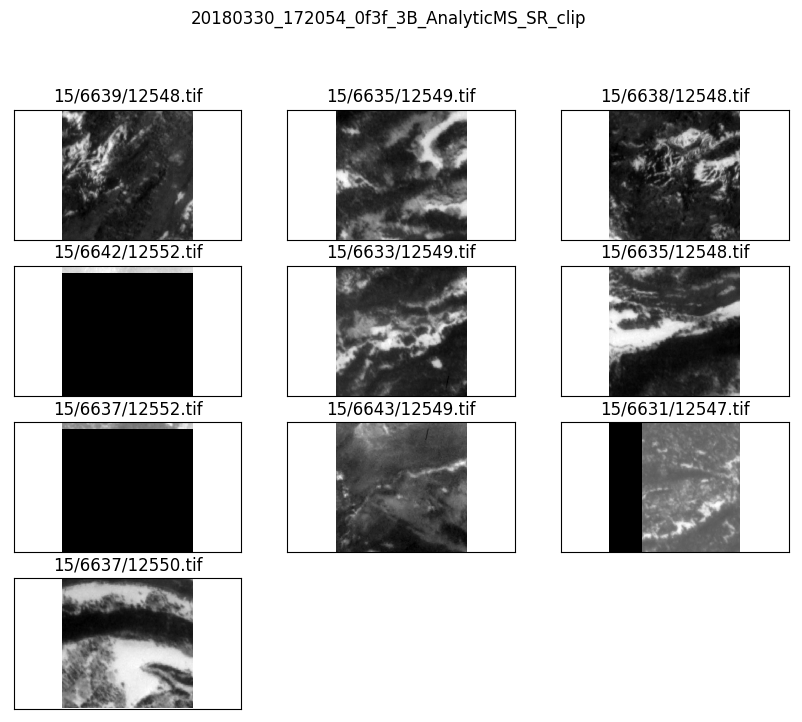

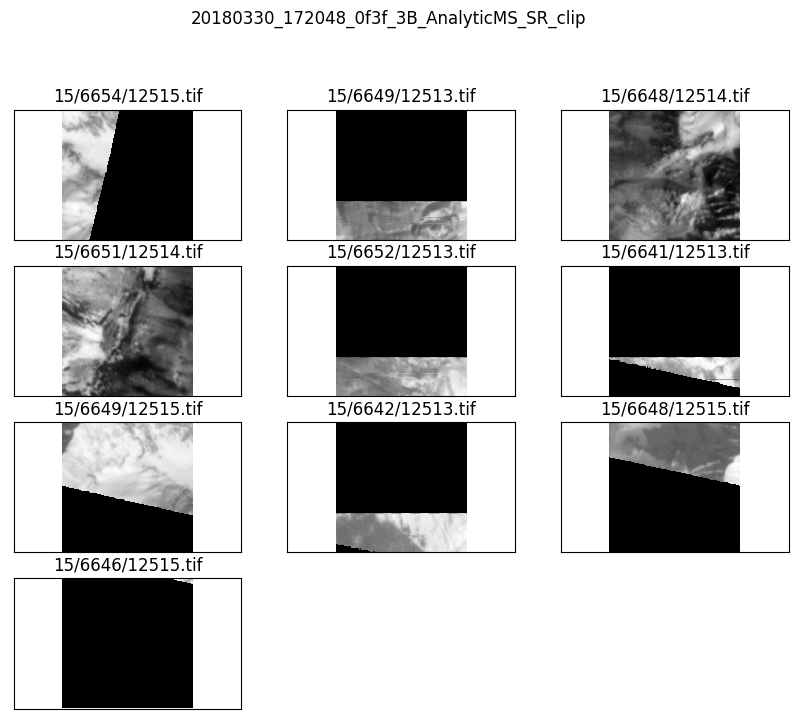

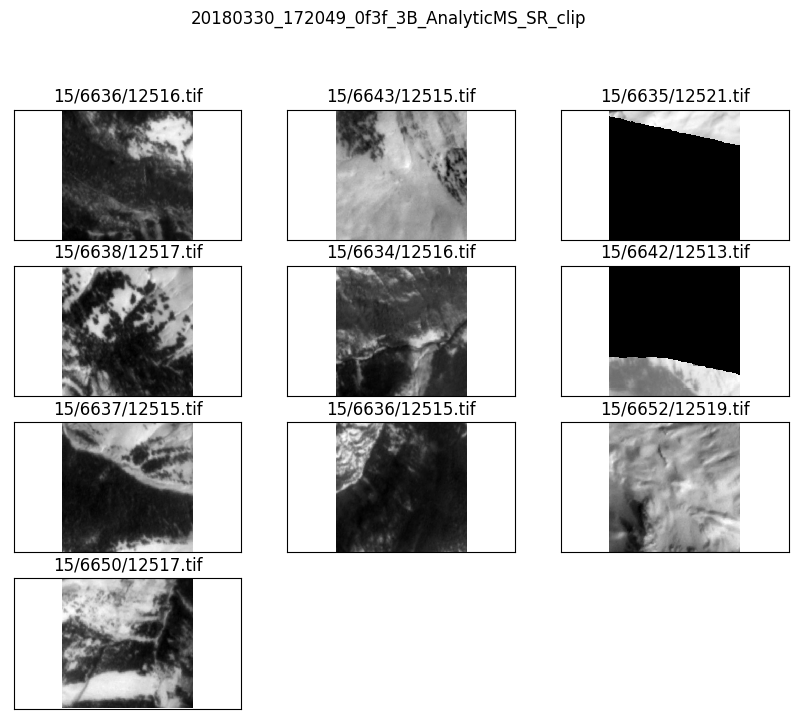

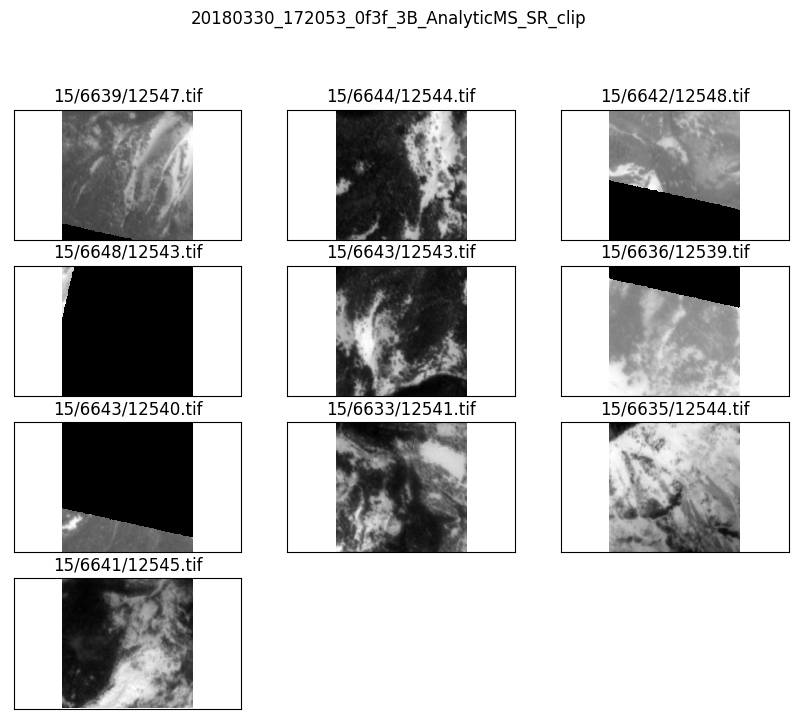

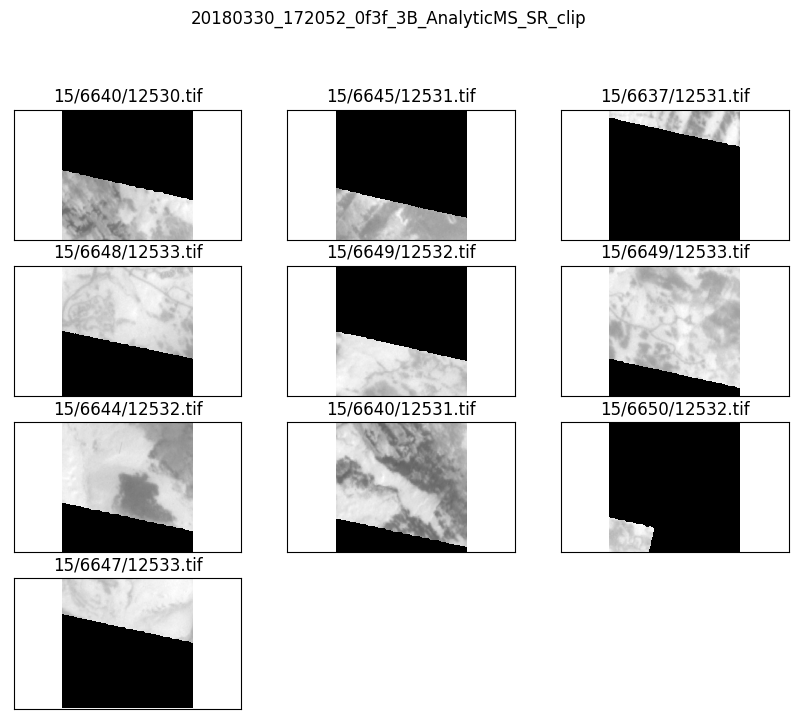

In [170]:
## Check some tiles
fs = s3fs.S3FileSystem(session= boto3.Session(profile_name = 'esip'))

for image in images:
    imageId = os.path.basename(image).split('.')[0]
    tiles = fs.walk('planet-snowcover-imagery/{}'.format(imageId))
    print(len(tiles))
    
    sampTiles = sample(tiles, 10)
    fig = plt.figure(figsize = (10, 10), dpi = 100)
    grid = plt.GridSpec(5, 3)
    plt.suptitle(imageId)

    with rio.Env(profile_name='esip'):
        for i, t in enumerate(sampTiles):
            tile = '/'.join(t.split('/')[-3:])
            ax = plt.subplot(grid[i])
            ax.set_title(tile)
            ax.axis('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            show(rio.open('s3://' + t).read(4), cmap='binary_r', ax = ax)
        



## In Summary

We've started with an ASO collect, identified relevant Planet assets, ordered those clipped assets from Planet, and processed them into tiles that live on Amazon S3. Below are the S3 folders that contain these tiled assets for reference during model training. We'll put them in a file. 

In [175]:
assets =["s3://planet-snowcover-imagery/{}/".format(os.path.basename(image).split('.')[0]) for image in images]
assets

['s3://planet-snowcover-imagery/20180330_172054_0f3f_3B_AnalyticMS_SR_clip/',
 's3://planet-snowcover-imagery/20180330_172048_0f3f_3B_AnalyticMS_SR_clip/',
 's3://planet-snowcover-imagery/20180330_172049_0f3f_3B_AnalyticMS_SR_clip/',
 's3://planet-snowcover-imagery/20180330_172053_0f3f_3B_AnalyticMS_SR_clip/',
 's3://planet-snowcover-imagery/20180330_172052_0f3f_3B_AnalyticMS_SR_clip/']

In [180]:
pd.Series(assets).to_csv('/tmp/work/assets.csv', index = False)

In [181]:
!cat /tmp/work/assets.csv

s3://planet-snowcover-imagery/20180330_172054_0f3f_3B_AnalyticMS_SR_clip/
s3://planet-snowcover-imagery/20180330_172048_0f3f_3B_AnalyticMS_SR_clip/
s3://planet-snowcover-imagery/20180330_172049_0f3f_3B_AnalyticMS_SR_clip/
s3://planet-snowcover-imagery/20180330_172053_0f3f_3B_AnalyticMS_SR_clip/
s3://planet-snowcover-imagery/20180330_172052_0f3f_3B_AnalyticMS_SR_clip/


As a reminder, these images are overlapping with the following ASO collect:

In [182]:
collect.value

'/tmp/work/ASO_3M_SD_USCOCB_20180330.tif'

Running the below cell will determine the corresponding ASO tile locations, if any. 

In [205]:
collectTiles = 'planet-snowcover-snow/{}_binary'.format(os.path.splitext(os.path.basename(collect.value))[0])
print("Tiles located at \"{}\"".format(collectTiles)) if fs.exists(collectTiles) else "tiles not present on S3"

Tiles located at "planet-snowcover-snow/ASO_3M_SD_USCOCB_20180330_binary"


This ASO tile location, paired with the above imagery tile locations, is sufficient information to train the snow identification model. 

<div style="text-align:center" markdown="1">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Planet_logo_New.png/320px-Planet_logo_New.png" width=100/>
</div>